<a href="https://colab.research.google.com/github/yaniv256/VAEs-in-Economics/blob/master/Notebooks/Time_use_shares_with_vaes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras as keras
keras.__version__

'2.2.4-tf'

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np

img_shape = (389, )
batch_size = 16
latent_dim = 1  # Dimensionality of the latent space: a line
dense_width = 600
l2_penalty=0.00001
l1_penalty=0.0
dropout_rate=0.1
hidden_n = 1


In [4]:

input_img = keras.Input(shape=img_shape)

x = layers.Dense(dense_width, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(
                     l1=l1_penalty,l2=l2_penalty))(input_img)
x = layers.Dropout(dropout_rate)(x)

for i in range(hidden_n):
  x = layers.Dense(dense_width, activation='relu',kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(x)
  x = layers.Dropout(dropout_rate)(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Here is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to 
generate a latent space point `z`. Here, we wrap some arbitrary code (built on top of Keras backend primitives) into a `Lambda` layer. In 
Keras, everything needs to be a layer, so code that isn't part of a built-in layer should be wrapped in a `Lambda` (or else, in a custom 
layer).

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img,z_mean)


This is the decoder implementation: we reshape the vector `z` to the dimensions of an image, then we use a few convolution layers to obtain a final 
image output that has the same dimensions as the original `input_img`.

In [0]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(dense_width, activation='relu',kernel_regularizer=regularizers.l1_l2(
                     l1=l1_penalty,l2=l2_penalty))(decoder_input)
x = layers.Dropout(dropout_rate)(x)

for i in range(hidden_n):
  x = layers.Dense(dense_width, activation='relu',kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(x)
  x = layers.Dropout(dropout_rate)(x)


x = layers.Dense(img_shape[0], activation='relu',kernel_regularizer=regularizers.l1_l2(
                     l1=l1_penalty,l2=l2_penalty))(x)

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [35]:
import pandas as pd 
df=pd.read_csv("https://github.com/yaniv256/VAEs-in-Economics/blob/master/Data/Timeuse/time_shares_only_2013.csv?raw=true")
df

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,540,330,0,35,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,455,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,580,95,0,75,0,35,60,25,15,0,0,0,0,0,50,0,0,80,0,309,20,60,0,0,0,5,0,0,0,0,0,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,450,60,0,170,0,90,105,0,20,0,0,0,0,0,0,0,0,0,0,0,15,15,0,0,0,0,0,0,0,0,0,0,0,0,40,0,145,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,450,65,680,70,0,30,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,570,90,0,120,0,0,60,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,510,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [34]:

from sklearn.preprocessing import QuantileTransformer

qt_trans = QuantileTransformer(n_quantiles=1000, random_state=0)
qt = pd.DataFrame(qt_trans.fit_transform(df))
qt.columns = df.columns
qt

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,0.571572,0.831832,0.000000,0.304805,0.000000,0.311311,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.997387,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.693193,0.400901,0.000000,0.646146,0.000000,0.508008,0.825325,0.782282,0.791792,0.000000,0.0,0.000000,0.000000,0.000000,0.919920,0.0,0.000000,0.961962,0.0,0.995862,0.851852,0.958458,0.000000,0.000000,0.0,0.871371,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.877878,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.262262,0.304304,0.000000,0.958959,0.000000,0.903403,0.937437,0.000000,

In [0]:
from sklearn.model_selection import train_test_split 
x_train, x_test = train_test_split(qt, test_size=0.33, random_state=42)

In [11]:

import pandas as pd 
vae = Model(input_img, y)

vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=30,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 389)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 600)          234000      input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 600)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 600)          360600      dropout[0][0]                    
____________________________________________________________________________________________

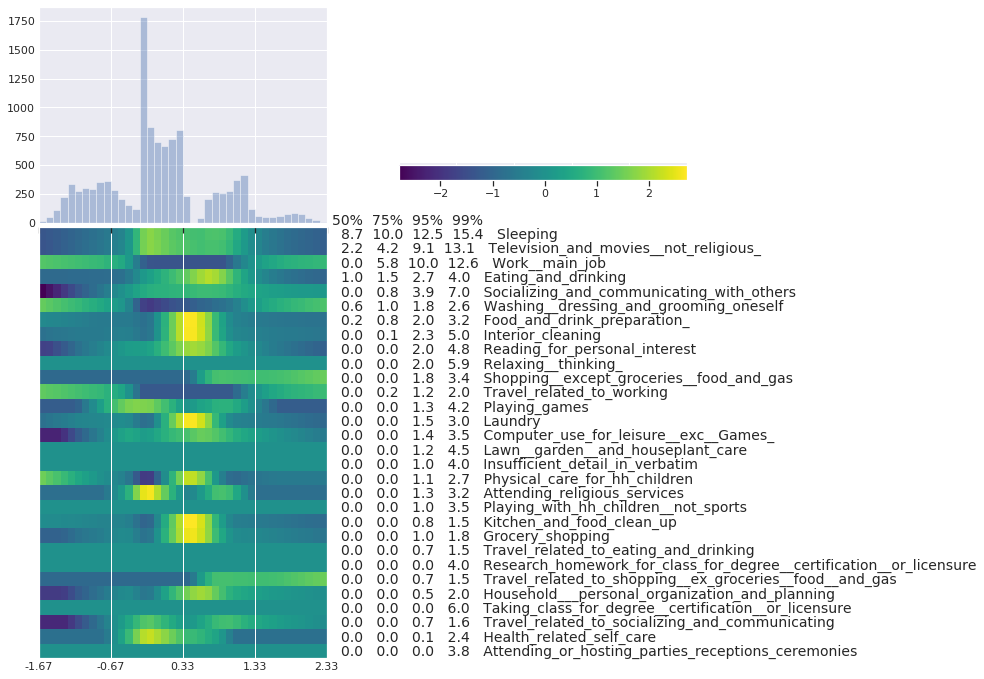

In [115]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import seaborn as sns


def plot_types(decoder, data, n_type = 40, each_hight = 20, approx_width=400, 
               n_activity =  30, lowest_percentile= 0.1, 
               highest_percentile = 99.9, figsize=(10, 10),
               cmap='viridis', n_xlabels=5, spacing = -0.02, standard_scaler=True):
  
  # definitions for the axes
  left, width = 0.05, 0.40
  bottom, height = 0.025, 0.65
  

  rect_scatter = [left, bottom, width, height]
  rect_histx = [left, bottom + height + spacing, width, 0.3]
  rect_colorbar = [left+width+0.1, bottom + height + spacing +0.05, width, 0.03]

  # start with a rectangular Figure
  plt.figure(figsize=figsize)

  ax_scatter = plt.axes(rect_scatter)
  ax_scatter.tick_params(direction='in', top=True, right=True)
  ax_histx = plt.axes(rect_histx)
  ax_histx.tick_params(direction='in', labelbottom=False)
  ax_colorbar = plt.axes(rect_colorbar)
  ax_colorbar.tick_params(direction='in', labelbottom=False, labelleft=False)

  each_width = np.int(np.ceil(approx_width/n_type))
  figure = np.zeros((each_hight*n_activity,n_type*each_width))
  # Linearly spaced coordinates on the unit square were transformed
  # through the inverse CDF (ppf) of the Gaussian
  # to produce values of the latent variables z,
  # since the prior of the latent space is Gaussian

  encoded_data=encoder.predict(data)

  lowest=np.percentile(encoded_data, lowest_percentile)
  highest=np.percentile(encoded_data, highest_percentile)

  #print(lowest,highest)

  grid_x = np.linspace(lowest, highest, n_type)

  for i, xi in enumerate(grid_x):
      z_sample = np.array([[xi]])
      x_decoded = decoder.predict(z_sample)
      figure[0:n_activity*each_hight,i*each_width : (i + 1)*each_width] = \
      np.repeat(x_decoded[0,0:n_activity],each_hight).reshape(n_activity*each_hight,1)

  if standard_scaler:
    figure=np.transpose(figure)
    scaler = StandardScaler()
    figure=scaler.fit_transform(figure)
    figure=np.transpose(figure)

  im = ax_scatter.imshow(figure, cmap=cmap)
  plt.colorbar(im, ax= ax_colorbar, orientation='horizontal', fraction=1)

  prec = pd.DataFrame(np.percentile(df,[50, 75, 95, 99],axis=0))

  ax_scatter.text(1.02*n_type*each_width,
                  0.8*each_hight -each_hight, '50%  75%  95%  99%', fontsize=14)

  for i in range(n_activity):

    ax_scatter.text(1.02*n_type*each_width,
                    0.8*each_hight+i*each_hight, 
                    '{:5.1f} {:5.1f} {:5.1f} {:5.1f}   '.format(prec.iloc[0,i]/60, 
                                                             prec.iloc[1,i]/60,
                                                             prec.iloc[2,i]/60,
                                                             prec.iloc[3,i]/60)  
                    + df.columns[i], fontsize=14)

  bins=np.append(grid_x-(grid_x[1]-grid_x[0])/2,
                 grid_x[n_type-1]+(grid_x[1]-grid_x[0])/2)

  
  ax_scatter.set_xticks( np.linspace(0,n_type*each_width,n_xlabels))
  ax_scatter.set_xticklabels(np.round(np.linspace(bins[0], bins[n_type], n_xlabels),
                                      decimals=2))  
  ax_scatter.set_yticks([])
  plt.xlabel('Encoded space')

  sns.set()
  sns.set_style("darkgrid")

  ax_histx.set_xticks( np.linspace(bins[0], bins[n_type], n_xlabels))
  ax_histx.set_xticklabels(np.round(np.linspace(bins[0], bins[n_type], n_xlabels),
                                      decimals=2))
  
  sns.distplot(encoded_data,ax=ax_histx,bins=bins,kde=False,
               rug=False).set_xlim(bins[0],bins[n_type])
  
  plt.savefig('type_plot.png')

  plt.show()

plot_types(decoder,qt, standard_scaler = True);

In [28]:
encoded_data=encoder.predict(qt)
pd.DataFrame(encoded_data)

,0
0,-0.191034
1,0.314733
2,0.333944
3,-0.945067
4,0.040950
...,...
11380,-0.161124
11381,-0.753240
11382,-1.017214
11383,-0.178357


In [29]:
filtered=pd.DataFrame((decoder.predict(encoded_data)))
filtered.columns = df.columns
filtered

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,0.548852,0.553255,0.047799,0.485359,0.316749,0.435818,0.267393,0.084627,0.172402,0.0,0.0,0.000000,0.101938,0.012175,0.118139,0.0,0.0,0.038787,0.137012,0.0,0.003396,0.034704,0.0,0.0,0.0,0.076351,0.0,0.228138,0.087235,0.0,0.0,0.0,0.0,0.0,0.0,0.062110,0.061812,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.509256,0.516659,0.000000,0.518664,0.334463,0.460634,0.676384,0.547483,0.291102,0.0,0.0,0.000000,0.051737,0.429134,0.156835,0.0,0.0,0.279381,0.029774,0.0,0.531901,0.354183,0.0,0.0,0.0,0.204279,0.0,0.159187,0.054833,0.0,0.0,0.0,0.0,0.0,0.0,0.064291,0.169611,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.508309,0.515868,0.000000,0.519887,0.334921,0.461154,0.691121,0.563926,0.295214,0.0,0.0,0.000000,0.049381,0.443

In [31]:
filtered-qt

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,-0.022720,-0.278577,0.047799,0.180554,0.316749,0.124507,0.267393,0.084627,0.172402,0.000000,0.0,0.000000,0.101938,0.012175,0.118139,0.0,0.000000,0.038787,0.137012,0.000000,0.003396,0.034704,0.000000,-0.997387,0.0,0.076351,0.0,0.228138,0.087235,0.000000,0.0,0.0,0.0,0.0,0.000000,0.062110,0.061812,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.183937,0.115758,0.000000,-0.127482,0.334463,-0.047374,-0.148941,-0.234800,-0.500690,0.000000,0.0,0.000000,0.051737,0.429134,-0.763085,0.0,0.000000,-0.682581,0.029774,-0.995862,-0.319951,-0.604275,0.000000,0.000000,0.0,-0.667093,0.0,0.159187,0.054833,0.000000,0.0,0.0,0.0,0.0,-0.877878,0.064291,0.169611,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.246047,0.211564,0.000000

In [0]:
import time
from google.colab import files

In [0]:
files.download('type_plot.png') 

In [0]:
pd.DataFrame(encoded_data).to_csv("encoded_data.csv", header=False, index=False)


In [0]:
files.download('encoded_data.csv') 

In [0]:
encoder.save_weights('encoder')

In [0]:
files.download('encoder.index') 
files.download('encoder.data-00000-of-00002') 
files.download('encoder.data-00001-of-00002') 

In [0]:
decoder.save_weights('decoder')

In [0]:
files.download('decoder.index') 
files.download('decoder.data-00000-of-00002') 
files.download('decoder.data-00001-of-00002') 

In [0]:
files.download('checkpoint') 